In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pathlib

import duckdb
import pandas as pd

from autoanalyst import entity, storage, transform, tree

# In-memory DB for quick work (change to 'mydb.duckdb' to persist)
DB_PATH = pathlib.Path("adventureworks.duckdb")

sales_cols = [
    "buyer_count",
    "active_days",
    "order_count",
    "order_lines",
    "order_quantity",
    "order_sales",
    "cost_production",
    "cost_tax",
    "cost_freight",
    "cost_discount",
    "weight_synthetic",
    "size_synthetic",
]

customer_cols = [
    "customer_id",
    "marital_status",
    "house_owner",
    "commute_distance",
    "cars_category",
    "children_category",
    "income_category",
    "country_region_code",
    "state_province_code",
    "city",
    "sales_territory",
    "activity_category",
    "customer_age_category",
]

reseller_cols = [
    "reseller_id",
    "business_type",
    "order_frequency",
    "product_line",
    "annual_sales",
    "annual_revenue",
    "country_region_code",
    "state_province_code",
    "city",
    "sales_territory",
    "activity_category",
]

business_unit_cols = [
    "report_date",
    "department_name",
]

opex_cols = [
    "report_date",
    "department_name",
    "headcount",
    "salary_cost",
    "benefits_cost",
    "overtime_cost",
    "training_cost",
    "travel_cost",
    "misc_labor_cost",
    "go_to_market_cost",
    "facilities_cost",
    "it_infra_cost",
    "fees_prof_services_cost",
    "misc_nonlabor_cost",
]

cogs_cols = [
    "cost_production",
    "cost_tax",
    "cost_freight",
    "cost_discount",
]


def read_query(query):
    """
    Read data from the DuckDB database.
    """
    with duckdb.connect(DB_PATH) as conn:
        return conn.execute(query).df()


internet_query = """
    select * from int__internetsales_orders
    order by customer_id, report_date
"""
reseller_query = """
    select * from int__resellersales_orders
    order by reseller_id, report_date
"""
business_unit_opex = """
    select * from int__department_costings
    where department_name != 'Corporate'
    order by department_name, report_date
"""

df_internet_sales = read_query(internet_query)
df_reseller_sales = read_query(reseller_query)
df_opex = read_query(business_unit_opex)


df_buyer_internet = df_internet_sales[customer_cols]
df_buyer_resale = df_reseller_sales[reseller_cols]

df_internet_sales[sales_cols].head()
# df_buyer_internet.head()
from duckdb import df


def process_sales_data(df, id_col, date_col):
    """
    Process sales data for metric demcomp
    """
    out = df[[id_col, date_col]].copy()

    out["buyer_count"] = df.buyer_count

    out["active_days_per_buyer"] = df.active_days / df.buyer_count
    out["order_count_per_active_day"] = df.order_count / df.active_days
    out["order_lines_per_order"] = df.order_lines / df.order_count
    out["order_units_per_line"] = df.order_quantity / df.order_lines
    out["order_sales_per_unit"] = df.order_sales / df.order_quantity

    total_costs = df[cogs_cols].sum(axis=1)

    out["cogs_profit_deflator"] = 1 + (total_costs / df.order_sales)

    cost_allocation_block = df[cogs_cols].copy().div(total_costs.values, axis=0)
    out[cogs_cols] = cost_allocation_block.mul(out.cogs_profit_deflator, axis=0)

    out["per_unit_weight"] = df.weight_synthetic / df.order_quantity
    out["per_unit_size"] = df.size_synthetic / df.order_quantity

    out["net_profit"] = df.order_sales + total_costs
    return out.fillna(0)


def process_opex_data(df, id_col="department_name", date_col="report_date"):
    """
    Process OPEX data for metric demcomp
    """
    out = df[[id_col, date_col, "headcount"]].copy()
    total_labor_costs = (
        df.salary_cost
        + df.benefits_cost
        + df.overtime_cost
        + df.training_cost
        + df.travel_cost
        + df.misc_labor_cost
    )
    total_nonlabor_cost = (
        df.go_to_market_cost
        + df.facilities_cost
        + df.it_infra_cost
        + df.fees_prof_services_cost
        + df.misc_nonlabor_cost
    )
    headcount = df.headcount.fillna(0)

    out["per_employee_labor_cost"] = total_labor_costs / headcount
    out["per_employee_salary_cost"] = df.salary_cost / headcount
    out["per_employee_benefits_cost"] = df.benefits_cost / headcount
    out["per_employee_overtime_cost"] = df.overtime_cost / headcount
    out["per_employee_training_cost"] = df.training_cost / headcount
    out["per_employee_travel_cost"] = df.travel_cost / headcount

    out["go_to_market_cost"] = df.go_to_market_cost
    out["facilities_cost"] = df.facilities_cost
    out["it_infra_cost"] = df.it_infra_cost
    out["fees_prof_services_cost"] = df.fees_prof_services_cost

    out["total_opex"] = total_labor_costs + total_nonlabor_cost
    out["total_nonlabor_cost"] = total_nonlabor_cost
    out["total_per_employee_labor_cost"] = total_labor_costs / headcount

    return out.fillna(0)


df_internet_sales_cleaned = process_sales_data(
    df_internet_sales,
    id_col="customer_id",
    date_col="report_date",
)

int_sales_dims = [
    col for col in customer_cols if col not in df_internet_sales_cleaned.columns
]
df_internet_sales_cleaned = pd.concat(
    [
        df_internet_sales_cleaned,
        df_buyer_internet[int_sales_dims],
    ],
    axis=1,
)


df_reseller_sales_cleaned = process_sales_data(
    df_reseller_sales,
    id_col="reseller_id",
    date_col="report_date",
)

df_opex_cleaned = process_opex_data(
    df_opex,
    id_col="department_name",
    date_col="report_date",
)


df_company = pd.concat(
    [
        df_internet_sales_cleaned.groupby("report_date")
        .net_profit.sum()
        .rename("internet_net_profit"),
        df_reseller_sales_cleaned.groupby("report_date")
        .net_profit.sum()
        .rename("reseller_net_profit"),
        df_opex_cleaned.groupby("report_date").total_opex.sum().rename("total_opex"),
    ],
    axis=1,
).reset_index()
df_company["net_position"] = (
    df_company.internet_net_profit
    + df_company.reseller_net_profit
    + df_company.total_opex
)
df_company["company_id"] = 1

rd = df_internet_sales_cleaned.iloc[1]["report_date"]
df_internet_sales_cleaned.iloc[1] = df_internet_sales_cleaned.iloc[0]
df_internet_sales_cleaned.loc[1, "cogs_profit_deflator"] = 1.0
df_internet_sales_cleaned.loc[1, "report_date"] = rd

In [ ]:
from autoanalyst import category_aggregation
from autoanalyst.category_aggregation.enhancers import (
    AbsoluteTimeEnhancer,
    ActivityCountEnhancer,
    CohortTimeEnhancer,
    LagStepEnhancer,
)
from autoanalyst.core import string_maps
from autoanalyst.core.base_classes import BaseEntity


def start_date_fn(X: pd.DataFrame, categories: pd.DataFrame) -> pd.Series:
    """
    Function to get the start date for each category.
    """

    date_map = (
        X.index.get_level_values(string_maps.DATE_COL)
        .to_series()
        .groupby(X.index.get_level_values(string_maps.ID_COL))
        .min()
    )
    date_reindexed = (
        X.index.get_level_values(string_maps.ID_COL).to_series().map(date_map)
    )
    return pd.Series(
        date_reindexed.values,
        name="start_date",
        index=X.index,
    )


lag_step = LagStepEnhancer()
absolute_time = AbsoluteTimeEnhancer(
    start_date=pd.Timestamp("2011-01-01"), end_date=pd.Timestamp("2014-01-01")
)
cohort_time = CohortTimeEnhancer(
    start_identifier=start_date_fn,
    duration=pd.Timedelta(days=365),
)
activity_count = ActivityCountEnhancer(
    event_identifier=lambda X, cats: X["buyer_count"] != 0,
)
abs_time_enhancer = AbsoluteTimeEnhancer(
    start_date=pd.Timestamp("2011-01-01"), end_date=pd.Timestamp("2014-01-01")
)

buyer_preprocessors = [
    abs_time_enhancer,
    CohortTimeEnhancer(
        start_identifier=start_date_fn,
        duration=pd.Timedelta(days=365),
    ),
    ActivityCountEnhancer(
        event_identifier=lambda X, cats: X["buyer_count"] != 0,
    ),
]

dept_preprocessors = [
    LagStepEnhancer(),
]


company_entity = entity.DataFrameEntity(
    name="company",
    df=df_company,
    id_col="company_id",
    date_col="report_date",
    dim_cols=[],
    metric_cols=[
        "internet_net_profit",
        "reseller_net_profit",
        "total_opex",
        "net_position",
    ],
    category_aggregator=category_aggregation.NoOpAggregator(),
)

internet_customer_entity = entity.DataFrameEntity(
    name="internet_customer",
    df=df_internet_sales_cleaned,
    id_col="customer_id",
    date_col="report_date",
    dim_cols=int_sales_dims,
    metric_cols=[
        "buyer_count",
        "active_days_per_buyer",
        "order_count_per_active_day",
        "order_lines_per_order",
        "order_units_per_line",
        "order_sales_per_unit",
        "cogs_profit_deflator",
        "cost_production",
        "cost_tax",
        "cost_freight",
        "cost_discount",
        "net_profit",
        "per_unit_weight",
        "per_unit_size",
    ],
    category_aggregator=category_aggregation.SignatureKernelAggregator(
        preprocessors=buyer_preprocessors,
        signature_depth=2,
        projection_size=150,
    ),
)

company_topline = tree.MetricTreeNode(
    name="company_topline",
    entity=company_entity.name,
    head_col="net_position",
    children_cols=["reseller_net_profit", "internet_net_profit", "total_opex"],
    parent_node_lookup=None,  # parent node is the root
    transform=transform.SubtotalTransform(),
)

internet_profit = tree.MetricTreeNode(
    name="internet_profit",
    entity=internet_customer_entity.name,
    head_col="net_profit",
    children_cols=[
        "buyer_count",
        "active_days_per_buyer",
        "order_count_per_active_day",
        "order_lines_per_order",
        "order_units_per_line",
        "order_sales_per_unit",
        "cogs_profit_deflator",
    ],
    parent_node_lookup=tree.ParentColLink(
        node_name="company_topline",
        child_col="internet_net_profit",
    ),
    transform=transform.MetricDecompTransform(),
)


cogs_deflator = tree.MetricTreeNode(
    name="cogs_deflator",
    entity=internet_customer_entity.name,
    head_col="cogs_profit_deflator",
    children_cols=[
        "cost_production",
        "cost_tax",
        "cost_freight",
        "cost_discount",
    ],
    parent_node_lookup=tree.ParentColLink(
        node_name="internet_profit",
        child_col="cogs_profit_deflator",
    ),
    transform=transform.SubtotalTransform(),
)

internet_freight_breakdown = tree.MetricTreeNode(
    name="internet_freight_breakdown",
    entity=internet_customer_entity.name,
    head_col="cost_freight",
    children_cols=["per_unit_weight", "per_unit_size"],
    parent_node_lookup=tree.ParentColLink(
        node_name="cogs_deflator",
        child_col="cost_freight",
    ),
    transform=transform.NonzeroRegression(),
)

tree_nodes = [
    company_topline,
    internet_profit,
    cogs_deflator,
    internet_freight_breakdown,
]

tree_entities: list[BaseEntity] = [
    company_entity,
    internet_customer_entity,
]

storage_module = storage.DataFrameStorageModule()


metric_tree = tree.MetricTree(
    name="adventureworks_tree",
    entities=tree_entities,
    nodes=tree_nodes,
    storage_module=storage_module,
)

In [ ]:
metric_tree.standardise_units()

In [ ]:
metric_tree.standardise_categories()

100%|██████████| 16836/16836 [00:10<00:00, 1575.80it/s]


In [89]:
metric_tree.storage_module.processed_categories["internet_customer"].city.value_counts()[50:]

city
South Melbourne          1109
Shawnee                  1103
Findon                   1101
Lane Cove                1092
Coronado                 1082
                         ... 
Campbellsville              7
Chehalis                    3
Casper                      2
Bluffton--Cheektowaga       2
Byron                       1
Name: count, Length: 196, dtype: int64

In [ ]:
check = metric_tree.storage_module.load_dataset("internet_freight_breakdown")
check_cats = metric_tree.entities["internet_customer"].load_dims()
check_cats.index = check_cats.index.rename(["__DATE__", "__ID__"])
check

per_unit_weight  per_unit_size  __CONSTANT__  __RESIDUAL__  \
__DATE__   __ID__                                                               
2010-12-01 11003          0.141426       5.101956      0.808019 -4.394535e-09   
           11005          0.140386       5.064441      0.802077  1.744900e-08   
           11011          0.141426       5.101956      0.808019 -4.394535e-09   
           14501          0.023264       0.839242      0.166143  6.205365e-02   
           16351          0.119073       4.295583      0.850387 -9.074741e-02   
...                            ...            ...           ...           ...   
2013-11-01 29479          0.000000       0.000000      0.000000  0.000000e+00   
           29480          0.000000       0.000000      0.000000  0.000000e+00   
           29481          0.000000       0.000000      0.000000  0.000000e+00   
           29482          0.000000       0.000000      0.000000  0.000000e+00   
           29483          0.000000       0.000000      0.000000  0.000000e+00   

                   cost_freight  
__DATE__   __ID__                
2010-12-01 11003       6.051400  
           11005       6.006904  
           11011       6.051400  
           14501       1.090702  
           16351       5.174296  
...                         ...  
2013-11-01 29479       0.000000  
           29480       0.000000  
           29481       0.000000  
           29482       0.000000  
           29483       0.000000  

[184665 rows x 5 columns]

In [ ]:
import string

cats = pd.concat([check.copy().add_suffix(f"_{idx}") for idx in range(4)], axis=1)
cats = check_cats
out, labels = signature_kernel.aggregate_raw(check, cats)

100%|██████████| 16836/16836 [00:02<00:00, 6559.97it/s]


In [ ]:
internet_customer_entity.category_aggregator._agg_categories(check_cats, labels)

NameError: name 'check_cats' is not defined

cluster_label
 14    5035
 16    3342
-1     2023
 5      716
 13     681
 9      680
 10     562
 6      560
 15     558
 17     451
 18     377
 8      298
 12     255
 3      244
 4      225
 11     212
 0      171
 7      160
 1      146
 2      140
Name: count, dtype: int64


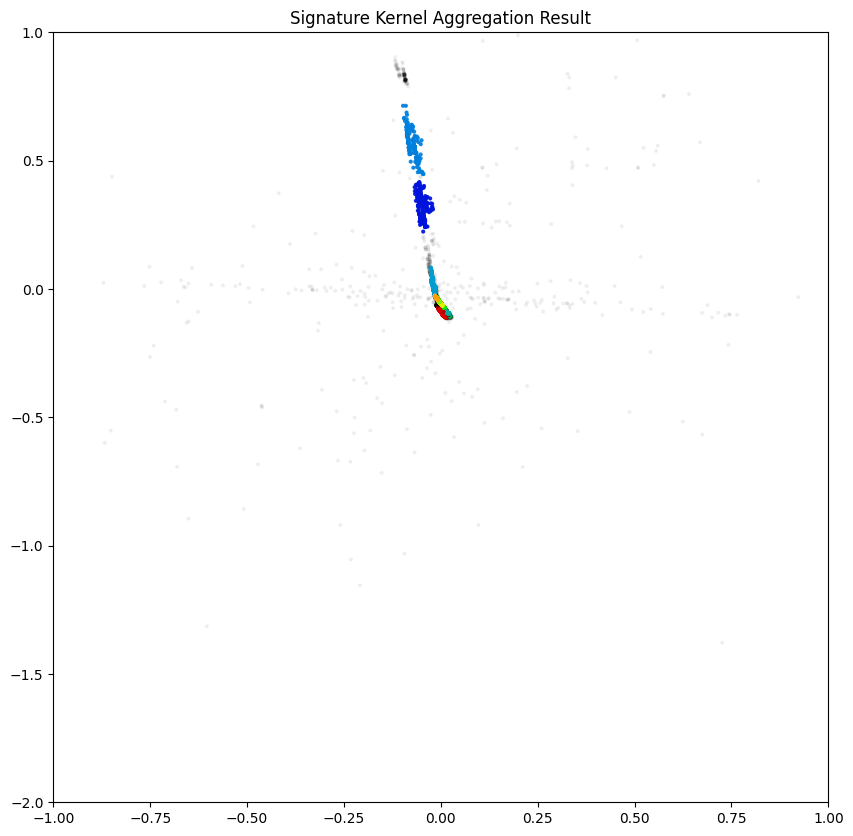

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA, FactorAnalysis

print(pd.Series(labels).value_counts())


pca = PCA(n_components=3, whiten=True)
# pca = FactorAnalysis(n_components=3, rotation="varimax")
out_tx = pca.fit_transform(out)  # Z_k = (n_users × 30) from Cholesky
alphas = ((labels != -1) + 0.05) / 1.2

# print("variance explained:", pca.explained_variance_ratio_.sum())
plt.figure(figsize=(10, 10))
plt.scatter(
    out_tx[:, 0], out_tx[:, 1], s=4, c=labels, cmap="nipy_spectral", alpha=alphas
)
plt.title("Signature Kernel Aggregation Result")
plt.xlim(-1, 1)
plt.ylim(-2, 1)
# plt.xlim(-0.1, 0.05)
# plt.ylim(-0.05, 0.1)
plt.show()

In [ ]:
import esig
import numpy as np

esig.logsigdim(17, 2)

153

In [ ]:
from autoanalyst.transform import NonzeroRegression

test_x = (
    df_internet_sales_cleaned.head(10000)
    .copy()
    .set_index(["report_date", "customer_id"])[
        ["cost_freight", "per_unit_weight", "per_unit_size"]
    ]
)

test_y = test_x.pop("cost_freight")

tx = NonzeroRegression(id_col="customer_id", date_col="report_date")

# tx.fit_transform(test_x, test_y)
tx.fit(test_x, test_y)

In [ ]:
test_y[test_y > 0].groupby("report_date").count()

report_date
2010-12-01      3
2011-01-01     27
2011-02-01     22
2011-03-01      8
2011-04-01     17
2011-05-01     19
2011-06-01     19
2011-07-01     19
2011-08-01     22
2011-09-01     48
2011-10-01      8
2011-11-01      6
2011-12-01      7
2012-01-01     10
2012-02-01      6
2012-03-01      3
2012-05-01      2
2012-09-01      3
2012-10-01      8
2012-11-01     13
2012-12-01     39
2013-01-01    144
2013-02-01    132
2013-03-01    129
2013-04-01     87
2013-05-01     92
2013-06-01    108
2013-07-01     98
2013-08-01     88
2013-09-01     82
2013-10-01     96
2013-11-01    101
Name: cost_freight, dtype: int64

In [ ]:
df_internet_sales_cleaned[
    [
        "buyer_count",
        "active_days_per_buyer",
        "order_count_per_active_day",
        "order_lines_per_order",
        "order_units_per_line",
        "order_sales_per_unit",
        "cogs_profit_deflator",
    ]
]

,buyer_count,active_days_per_buyer,order_count_per_active_day,order_lines_per_order,order_units_per_line,order_sales_per_unit,cogs_profit_deflator
0,1,1.0,1.0,1.0,1.0,3399.99,0.3326
1,1,1.0,1.0,1.0,1.0,3399.99,1.0000
2,0,0.0,0.0,0.0,0.0,0.00,0.0000
3,0,0.0,0.0,0.0,0.0,0.00,0.0000
4,0,0.0,0.0,0.0,0.0,0.00,0.0000
...,...,...,...,...,...,...,...
184660,0,0.0,0.0,0.0,0.0,0.00,0.0000
184661,0,0.0,0.0,0.0,0.0,0.00,0.0000
184662,0,0.0,0.0,0.0,0.0,0.00,0.0000
184663,0,0.0,0.0,0.0,0.0,0.00,0.0000


In [ ]:
import numpy as np

tmp = df_internet_sales_cleaned.cogs_profit_deflator.head(30)
tmp_zero = tmp == 0.0
tmp = tmp.replace({0.0: 1.0})
tmp_pd = pd.Series([0] + tmp.sub(1).to_list()).diff()[1:]
tmp_pd[tmp_zero.values] = np.nan
tmp_pd

1    -0.667400
2     0.667400
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25   -0.648918
26         NaN
27         NaN
28         NaN
29   -0.722984
30         NaN
dtype: float64

<Axes: xlabel='report_date'>

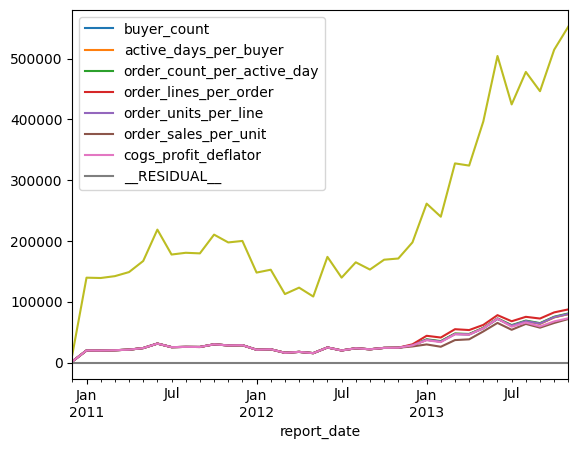

In [ ]:
tx.groupby("__DATE__").sum().plot()
orig.net_profit.groupby("report_date").sum().plot()

In [ ]:
first_value = (
    orig.net_profit[orig.index.get_level_values("customer_id") == 11003]
    .groupby("customer_id")
    .first()
)
tx_condensed: pd.Series = (tx[tx.index.get_level_values("__ID__") == 11003]).sum(axis=1)
first_spread = (
    tx_condensed.index.get_level_values("__ID__")
    .map(first_value.to_dict())
    .to_series(index=tx_condensed.index)
)
(
    tx_condensed.sort_index(ascending=False).mul(-1).cumsum().sort_index(ascending=True)
    + tx_condensed
).round(9) < 0

__DATE__    __ID__
2010-12-01  11003     False
2011-01-01  11003     False
2011-02-01  11003     False
2011-03-01  11003     False
2011-04-01  11003     False
2011-05-01  11003     False
2011-06-01  11003     False
2011-07-01  11003     False
2011-08-01  11003     False
2011-09-01  11003     False
2011-10-01  11003     False
2011-11-01  11003     False
2011-12-01  11003     False
2012-01-01  11003     False
2012-02-01  11003     False
2012-03-01  11003     False
2012-04-01  11003     False
2012-05-01  11003     False
2012-06-01  11003     False
2012-07-01  11003     False
2012-08-01  11003     False
2012-09-01  11003     False
2012-10-01  11003     False
2012-11-01  11003     False
2012-12-01  11003     False
2013-01-01  11003     False
2013-02-01  11003     False
2013-03-01  11003     False
2013-04-01  11003     False
2013-05-01  11003     False
2013-06-01  11003     False
2013-07-01  11003     False
2013-08-01  11003     False
2013-09-01  11003     False
2013-10-01  11003     False
2

In [ ]:
orig.net_profit[orig.index.get_level_values("customer_id") == 11003]

report_date  customer_id
2010-12-01   11003          1130.8366
2011-01-01   11003             0.0000
2011-02-01   11003             0.0000
2011-03-01   11003             0.0000
2011-04-01   11003             0.0000
2011-05-01   11003             0.0000
2011-06-01   11003             0.0000
2011-07-01   11003             0.0000
2011-08-01   11003             0.0000
2011-09-01   11003             0.0000
2011-10-01   11003             0.0000
2011-11-01   11003             0.0000
2011-12-01   11003             0.0000
2012-01-01   11003             0.0000
2012-02-01   11003             0.0000
2012-03-01   11003             0.0000
2012-04-01   11003             0.0000
2012-05-01   11003             0.0000
2012-06-01   11003             0.0000
2012-07-01   11003             0.0000
2012-08-01   11003             0.0000
2012-09-01   11003             0.0000
2012-10-01   11003             0.0000
2012-11-01   11003             0.0000
2012-12-01   11003             0.0000
2013-01-01   11003       

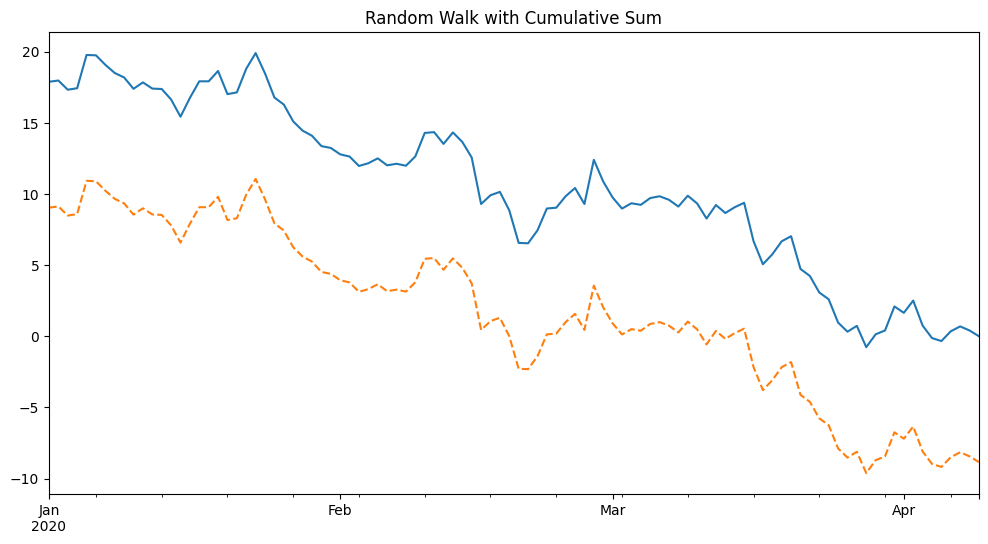

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SIZE = 100
nrm = pd.Series(
    np.random.randn(SIZE), index=pd.date_range("2020-01-01", periods=SIZE, freq="D")
)
nrm = nrm.cumsum().rename("Random Walk") + 10
dff = nrm.diff().fillna(0)
recon = (
    dff.sort_index(ascending=False).mul(-1).cumsum().sort_index(ascending=True) + dff
).round(9)
# recon = dff.cumsum()

plt.figure(figsize=(12, 6))
recon.plot(title="Random Walk with Cumulative Sum", grid=True)
nrm.plot(style="--", label="Original Series")
plt.show()

In [ ]:
idx = pd.date_range("2020-01-01", periods=SIZE, freq="D")
df = (
    pd.concat(
        [
            pd.Series(np.random.randn(SIZE), name="met1"),
            pd.Series(np.random.randn(SIZE), name="met2"),
            pd.Series(np.random.randn(SIZE), name="met3"),
            pd.Series(["a"] * (SIZE // 2) + ["b"] * (SIZE // 2), name="grp"),
            pd.Series(idx, name="report_date"),
        ],
        axis=1,
    )
    .set_index(["grp", "report_date"])
    .sort_index()
)


def padded_diff_shift(inner):
    diffed = [[0.0] * inner.shape[1]] + inner.values.tolist()
    diffed = pd.DataFrame(diffed, columns=inner.columns)
    return (
        pd.concat(
            [diffed.shift(1).add_suffix("_l"), diffed.diff(1).add_suffix("_d")], axis=1
        )
        .dropna()
        .set_index(inner.index)
    )


df.groupby(["grp"]).apply(padded_diff_shift)

met1_l    met2_l    met3_l    met1_d    met2_d  \
grp grp report_date                                                     
a   a   2020-01-01   0.000000  0.000000  0.000000  0.601671 -0.980478   
        2020-01-02   0.601671 -0.980478  0.545477 -2.111396  1.070149   
        2020-01-03  -1.509725  0.089671 -0.310432  1.117124  0.413023   
        2020-01-04  -0.392600  0.502694 -1.067879  1.065224  1.001301   
        2020-01-05   0.672624  1.503995  1.140344 -1.237945 -1.804356   
...                       ...       ...       ...       ...       ...   
b   b   2020-04-05   1.450505 -0.385917 -0.759052 -2.008631  1.263319   
        2020-04-06  -0.558126  0.877402  0.663425  1.094177  0.223594   
        2020-04-07   0.536051  1.100996 -1.859814  0.156661 -0.841412   
        2020-04-08   0.692712  0.259584  0.772040 -0.207637  1.475694   
        2020-04-09   0.485075  1.735278 -1.201699 -0.283414 -1.308118   

                       met3_d  
grp grp report_date            
a   a   2020-01-01   0.545477  
        2020-01-02  -0.855908  
        2020-01-03  -0.757447  
        2020-01-04   2.208223  
        2020-01-05  -0.020049  
...                       ...  
b   b   2020-04-05   1.422477  
        2020-04-06  -2.523239  
        2020-04-07   2.631853  
        2020-04-08  -1.973739  
        2020-04-09   1.556639  

[100 rows x 6 columns]

In [ ]:
print(metric_tree.to_mermaid_string())

graph TD;
    subgraph Entity_company
        subgraph Node_company_topline
            company__company_topline__net_position["net_position"]
            company__company_topline__total_opex["total_opex"]
            company__company_topline__reseller_net_profit["reseller_net_profit"]
            company__company_topline__internet_net_profit["internet_net_profit"]
        end

    end

    subgraph Entity_internet_customer
        subgraph Node_internet_profit
            internet_customer__internet_profit__order_lines_per_order["order_lines_per_order"]
            internet_customer__internet_profit__order_units_per_line["order_units_per_line"]
            internet_customer__internet_profit__active_days_per_buyer["active_days_per_buyer"]
            internet_customer__internet_profit__cogs_profit_deflator["cogs_profit_deflator"]
            internet_customer__internet_profit__buyer_count["buyer_count"]
            internet_customer__internet_profit__net_profit["net_profit"]
          